<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_Disease_Recognition_using_CNN_models_resnet_50_%26_VGG_16_%26_Dense_Net_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11251        447  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3379        131  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  20

In [9]:
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


**Datasets**

Ocular Disease Intelligent Recognition (ODIR) is a structured
ophthalmic database of 5,000 patients with age, color fundus
photographs from left and right eyes and doctors' diagnostic
keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient
information collected by Shanggong Medical Technology Co.,
Ltd. from different hospitals/medical centers in China. In these
institutions, fundus images are captured by various cameras in
the market, such as Canon, Zeiss and Kowa, resulting into
varied image resolutions.

Annotations were labeled by trained human readers with quality
control management. They classify patient into eight labels
including:

- - Normal (N),
- - Diabetes (D),
- - Glaucoma (G),
- - Cataract (C),
- - Age related Macular Degeneration (A),
- - Hypertension (H),
- - Pathological Myopia (M),
- - Other diseases/abnormalities (O)

In [7]:
! unzip ocular-disease-recognition-odir5k

Archive:  ocular-disease-recognition-odir5k.zip
replace ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **ResNet50**

In [10]:
import numpy as np
import pandas as pd
import cv2 #It's a library that provides functions for computer vision tasks, such as image processing, feature extraction, and object detection.
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**`numpy (import numpy as np):`**

 - - **`numpy`** is a widely used library for numerical computations in Python.

- - The np alias is commonly used to refer to numpy functions and classes.

**`pandas (import pandas as pd):`**

- - **`pandas`** is a data manipulation library that provides data structures like DataFrames, which are used to store and manipulate tabular data.

**`cv2:`**

- - cv2 stands for OpenCV (Open Source Computer Vision Library).
- - It's a library that provides functions for computer vision tasks, such as image processing, feature extraction, and object detection.

**`random:`**

- - The random module is used to generate random numbers and perform random operations.

**`tqdm:`**

- - tqdm is a library that provides a progress bar for loops, making it easier to track the progress of lengthy computations.

**`matplotlib.pyplot (import matplotlib.pyplot as plt):`**

- - matplotlib is a popular plotting library for creating visualizations and graphs.
- - The pyplot submodule provides an interface similar to MATLAB's plotting.

**`sklearn.metrics:`**

- - sklearn (scikit-learn) is a machine learning library in Python.
metrics submodule contains functions for evaluating model performance, calculating metrics like accuracy, precision, recall, etc.

**`sklearn.model_selection:`**

- - This submodule contains tools for model selection and evaluation, such as splitting data into training and testing sets.

**`sklearn.preprocessing:`**

- - preprocessing submodule contains utilities for data preprocessing tasks, like scaling, transforming, and encoding data.

**`tensorflow.keras.preprocessing.image:`**

- - tensorflow.keras is part of the TensorFlow library and provides tools for building and training deep learning models.

- - The preprocessing.image submodule contains functions for loading and preprocessing images.

**`tensorflow.keras.applications.ResNet50:`**

- - ResNet50 is a popular deep neural network architecture for image classification.
- - It's pre-trained on a large dataset and can be used for transfer learning.

**`tensorflow.keras.models.Sequential:`**

- - Sequential is a class in Keras that allows you to create a linear stack of layers for building neural network models.

**`tensorflow.keras.layers:`**

- - This module provides various types of layers that can be added to a neural network model, such as dense (fully connected), convolutional, recurrent, etc.

**`tensorflow.keras.optimizers.Adam:`**

- - Adam is an optimization algorithm used to update the weights of a neural network during training.

**`tensorflow.keras.callbacks.EarlyStopping:`**

- - EarlyStopping is a callback that stops training when a monitored metric (like validation loss) stops improving, preventing overfitting.

In [11]:
#set random seed for reproducibility
random.seed(42)

In [12]:
#read the CSV file
df = pd.read_csv('/content/full_df.csv')
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [13]:
#Define a function to check if a keyword contains a "cataract"
def has_cataract(text):
  if "cataract" in text:
    return 1
  else:
    return 0

In [14]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [15]:
#create a new columns for left and right cataract
df['left_cataract'] = df['Left-Diagnostic Keywords'].apply(lambda x : has_cataract(x))
df['right_cataract'] = df['Right-Diagnostic Keywords'].apply(lambda x : has_cataract(x))

In [16]:
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0


In [17]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename',
       'left_cataract', 'right_cataract'],
      dtype='object')

In [18]:
#Total right cataract samples
df.right_cataract.value_counts()

0    6102
1     290
Name: right_cataract, dtype: int64

In [19]:
#Total right cataract samples
df.left_cataract.value_counts()

0    6088
1     304
Name: left_cataract, dtype: int64

In [20]:
#Get the filenames of left and Right Cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

In [21]:
print(len(left_cataract), len(right_cataract))

304 290


In [22]:
left_cataract[:10]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg'], dtype=object)

In [23]:
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [24]:
# Get a sample of Normal Fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

In [25]:
left_normal[:15]

array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
       '4176_left.jpg', '2711_left.jpg', '4614_left.jpg', '3174_left.jpg',
       '2862_left.jpg', '2424_left.jpg', '3193_left.jpg', '3306_left.jpg',
       '2961_left.jpg', '2425_left.jpg', '2858_left.jpg'], dtype=object)

In [26]:
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [27]:
# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

In [28]:
# Print the number of cataract and normal images
print(len(cataract), len(normal))

594 600


In [47]:
import os

# Define the dataset directory and image size
dataset_dir = "/content/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            # image = image / 255.0  # Scale pixel values to [0, 1]
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

In [48]:
# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

100%|██████████| 594/594 [00:02<00:00, 295.15it/s]


588


100%|██████████| 600/600 [00:02<00:00, 280.53it/s]

1188


In [49]:
dataset[0][0].shape

(224, 224, 3)

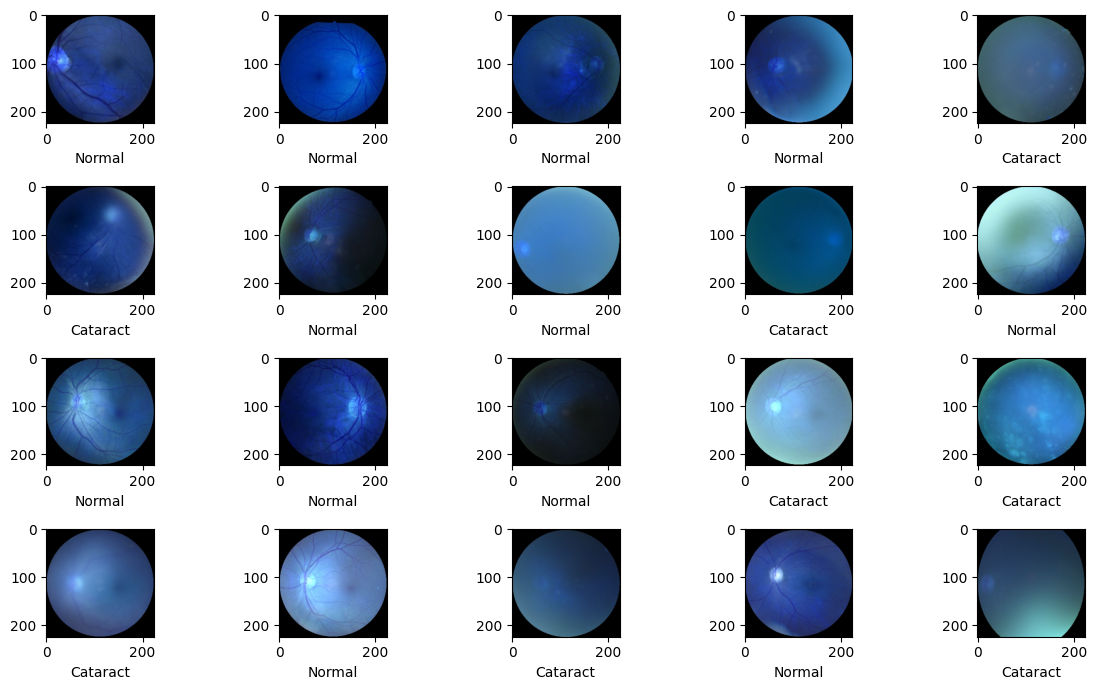

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 7))
for i in range(20):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]
  label = 'Normal' if category == 0 else 'Cataract'
  plt.subplot(4, 5, i+1)
  plt.imshow(image)
  plt.xlabel(label)
plt.tight_layout()

In [51]:
# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

In [52]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [53]:
# import tensorflow as tf
# tf.config.experimental.list_physical_devices()
# tf.test.is_built_with_cuda()

In [54]:
# def get_model():
from keras.applications.resnet import ResNet50

# Load the pre-trained ResNet-50 model with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))
base_model.save("model_name.h5")

from tensorflow.keras.models import load_model
resnet = load_model('model_name.h5')

# Create a new model based on ResNet-50
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
# return model

# with tf.device('/GPU:0'):
# Train the model
    #  cpu_model = get_model()
     # Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
30/30 [===================

In [55]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 92ms/step - loss: 0.2429 - accuracy: 0.9748
Test Loss: 0.2429233193397522
Test Accuracy: 0.9747899174690247


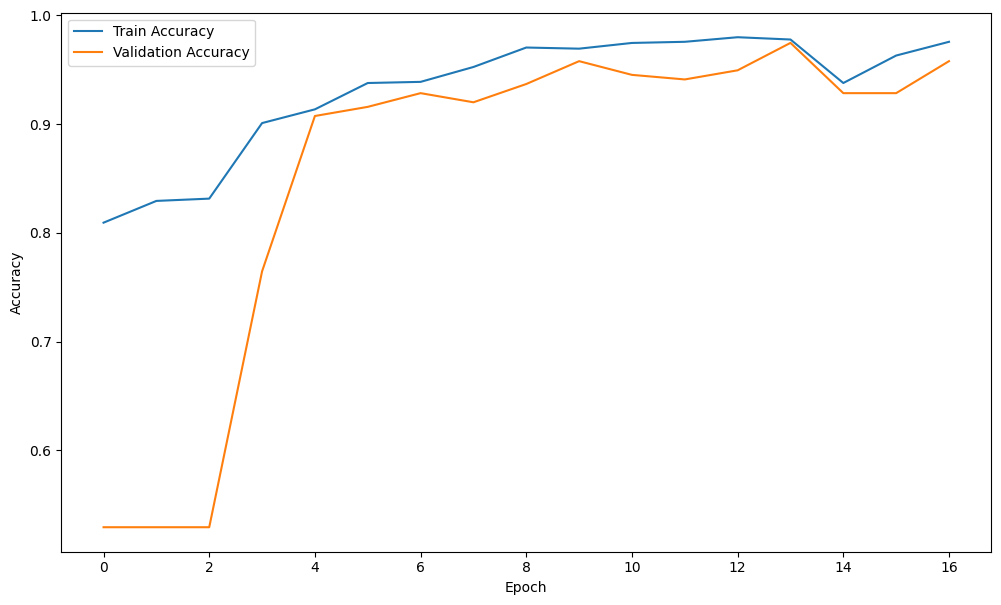

In [56]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

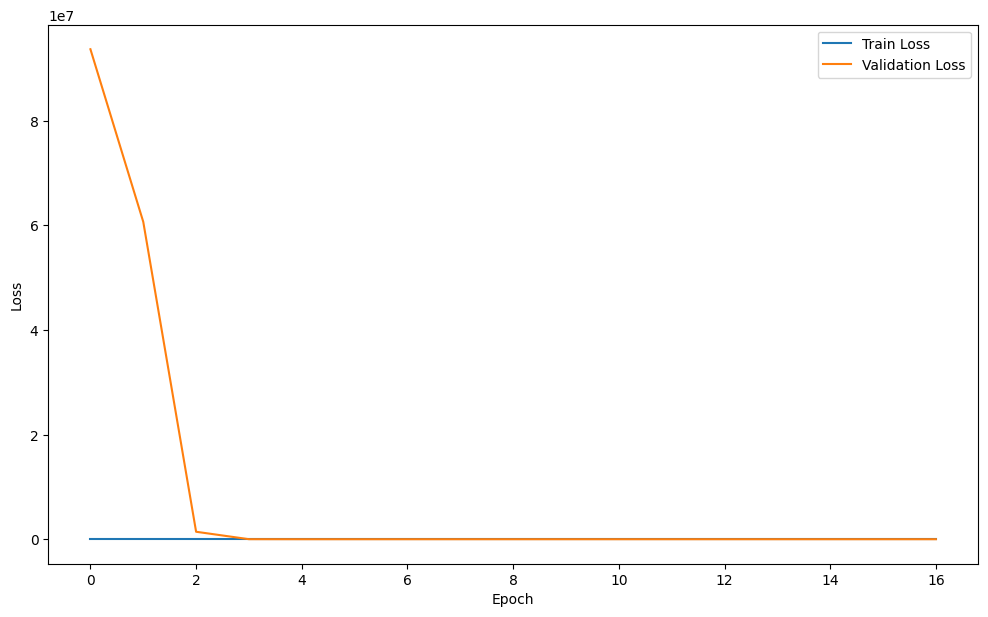

In [57]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

8/8 [==============================] - 2s 98ms/step


In [59]:
# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

In [60]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

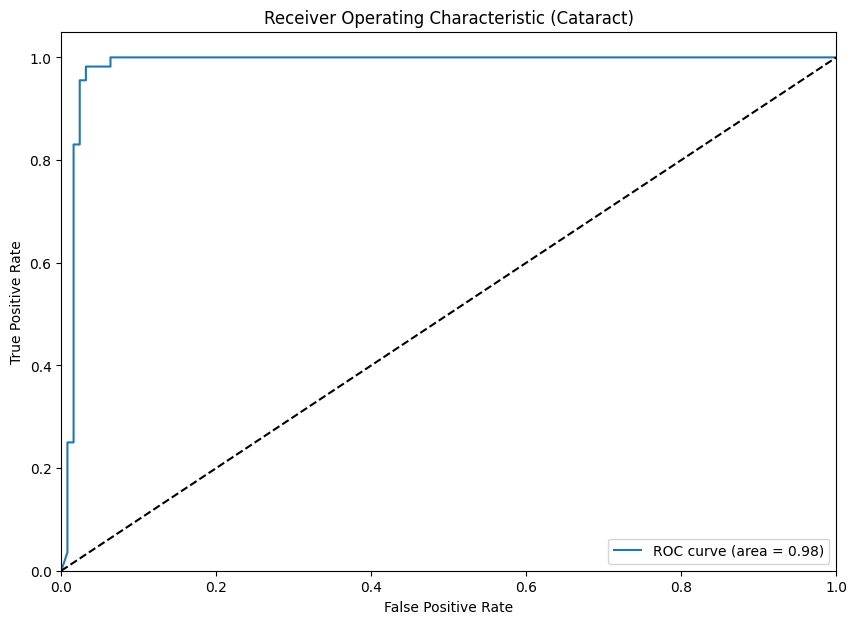

In [61]:
# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [62]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       126
    Cataract       0.96      0.98      0.97       112

    accuracy                           0.97       238
   macro avg       0.97      0.98      0.97       238
weighted avg       0.97      0.97      0.97       238



In [63]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 89ms/step - loss: 0.2429 - accuracy: 0.9748
Test Loss: 0.2429233193397522
Test Accuracy: 0.9747899174690247


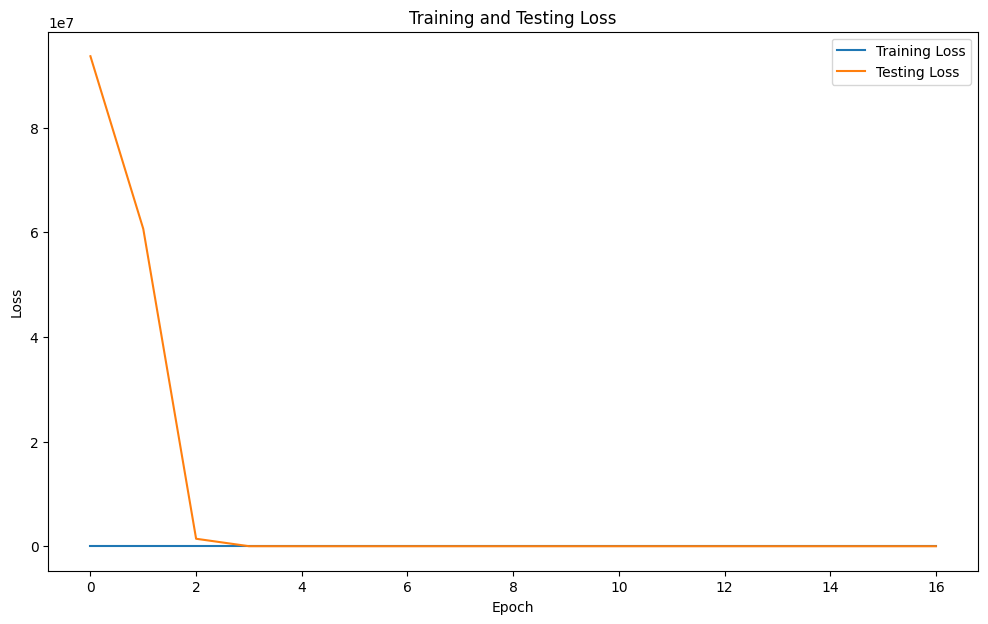

In [64]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

## **VGG16**

In [65]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

In [67]:
# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

0    6102
1     290
Name: right_cataract, dtype: int64


In [68]:
# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']


In [69]:
# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [70]:
# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print the first few filenames
print(right_normal[:15])
print(left_normal[:15])

['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']
['3332_left.jpg' '4059_left.jpg' '69_left.jpg' '2415_left.jpg'
 '4176_left.jpg' '2711_left.jpg' '4614_left.jpg' '3174_left.jpg'
 '2862_left.jpg' '2424_left.jpg' '3193_left.jpg' '3306_left.jpg'
 '2961_left.jpg' '2425_left.jpg' '2858_left.jpg']


In [71]:
# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

594 600


In [72]:
# Define the dataset directory and image size
dataset_dir = "/content/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

In [73]:
# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

100%|██████████| 594/594 [00:02<00:00, 293.82it/s]


588


100%|██████████| 600/600 [00:03<00:00, 190.41it/s]

1188


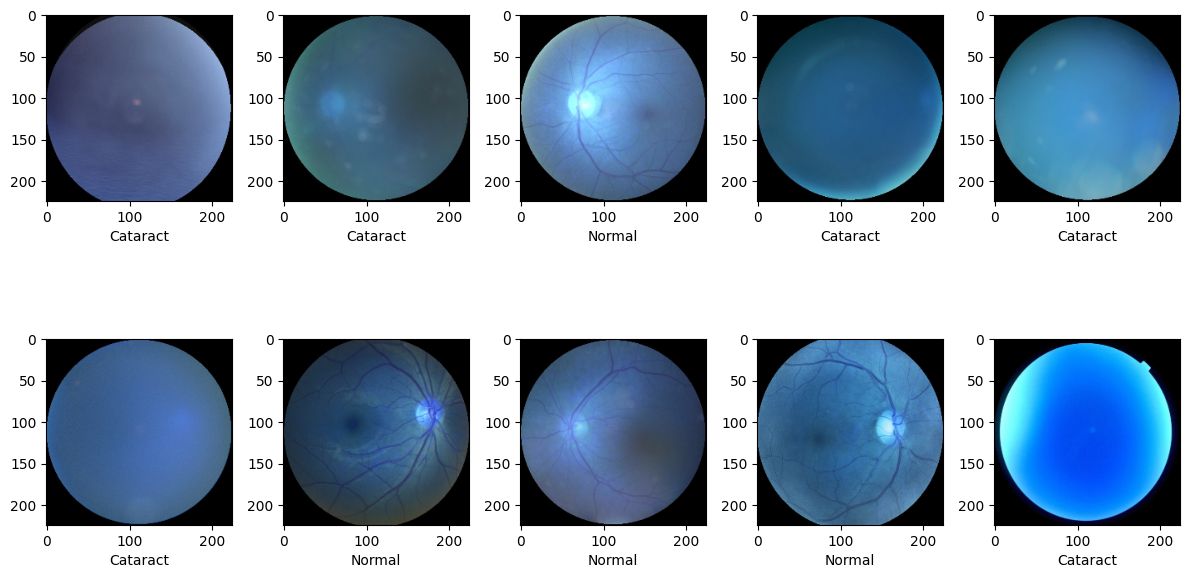

In [74]:
# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [81]:
# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [83]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Start the timer
start_time = time.time()

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on VGG16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint("VGG16.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 15.2495 - accuracy: 0.5168
Epoch 1: val_accuracy improved from -inf to 0.48739, saving model to VGG16.h5
30/30 [==============================] - 70s 465ms/step - loss: 15.2495 - accuracy: 0.5168 - val_loss: 0.7014 - val_accuracy: 0.4874
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5621
Epoch 2: val_accuracy improved from 0.48739 to 0.63025, saving model to VGG16.h5
30/30 [==============================] - 14s 466ms/step - loss: 0.6816 - accuracy: 0.5621 - val_loss: 0.6286 - val_accuracy: 0.6303
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6600
Epoch 3: val_accuracy improved from 0.63025 to 0.65126, saving model to VGG16.h5
30/30 [==============================] - 14s 457ms/step - loss: 0.6337 - accuracy: 0.6600 - val_loss: 0.6725 - val_accuracy: 0.6513
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.6649 - acc

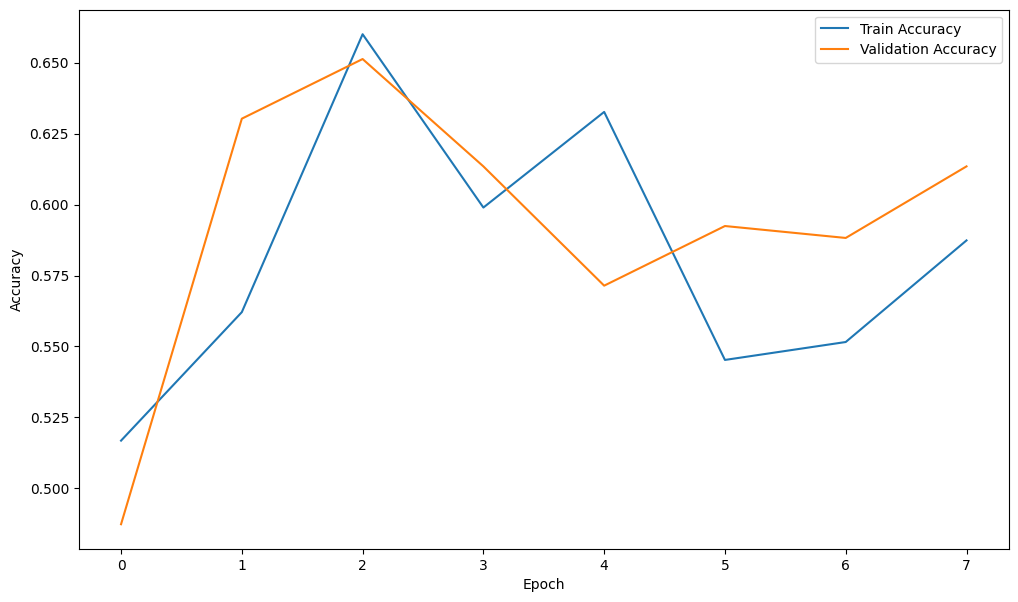

In [84]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

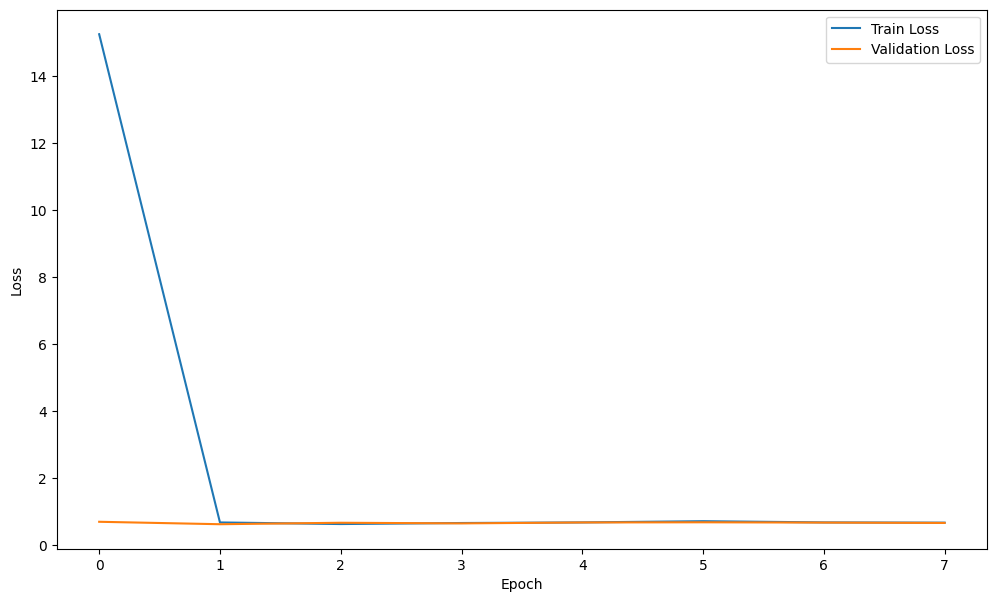

In [85]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

8/8 [==============================] - 1s 120ms/step


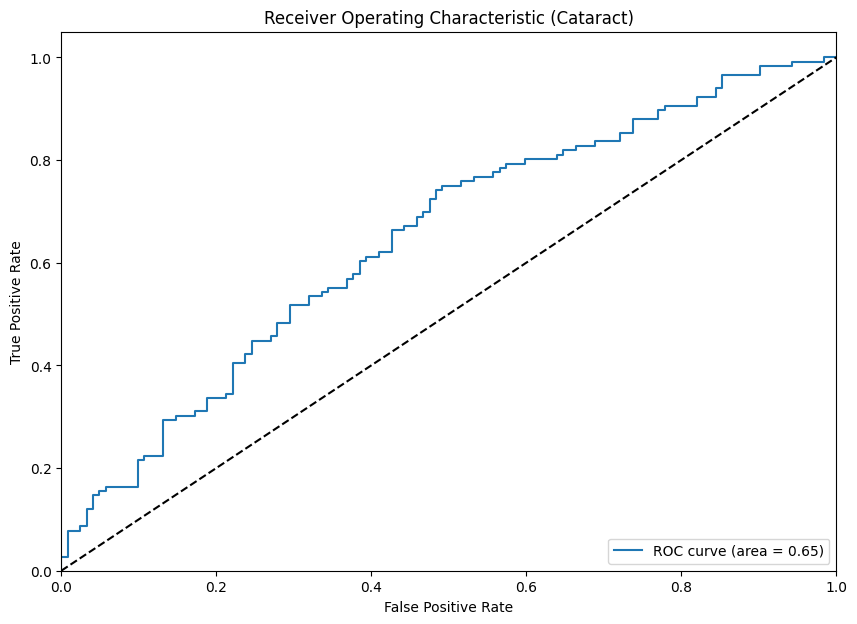

In [87]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [88]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.67      0.48      0.56       122
    Cataract       0.58      0.75      0.65       116

    accuracy                           0.61       238
   macro avg       0.63      0.62      0.61       238
weighted avg       0.63      0.61      0.61       238



In [89]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 114ms/step - loss: 0.6668 - accuracy: 0.6134
Test Loss: 0.6667837500572205
Test Accuracy: 0.6134454011917114


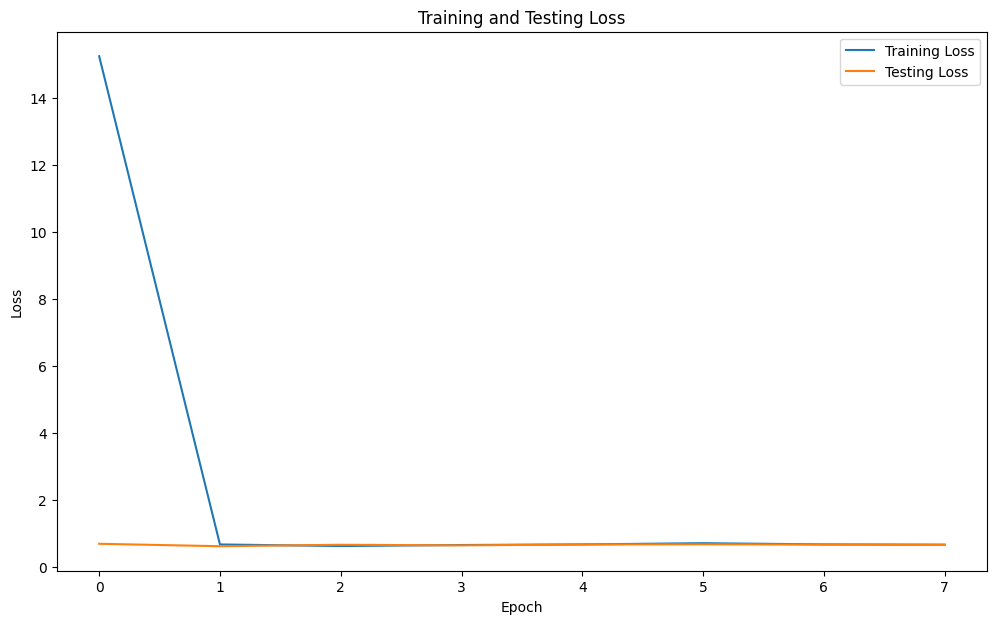

Training Time: 167.5448272228241 seconds


In [90]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')

(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

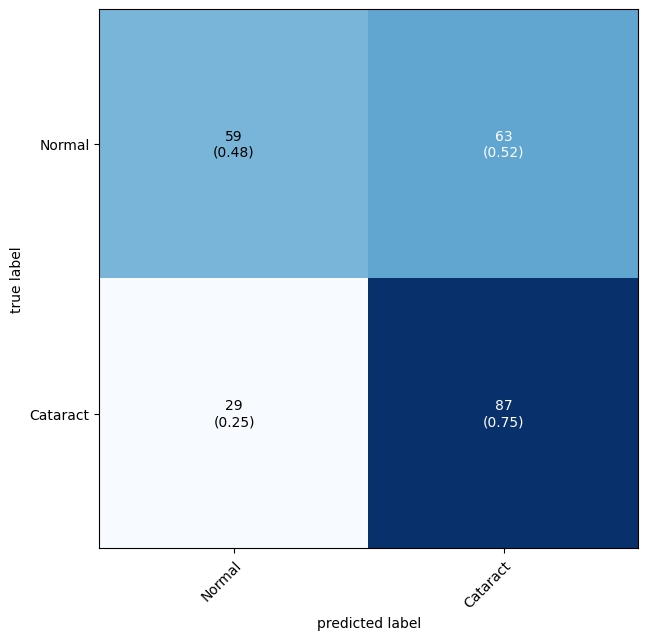

In [93]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Cataract"], show_normed=True)

## **DenseNet121**

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Start the timer
start_time = time.time()

# Load the pre-trained DenseNet-121 model
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Create a new model based on DenseNet-121
model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

29084464/29084464 [==============================] - 2s 0us/step


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_9 (Flatten)         (None, 50176)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               12845312  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 19,883,073
Trainable params: 19,799,425
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10


In [ ]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')
